# Learning to Learn using only CNN layers model on CIFAR-10

### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tqdm import tqdm
import tensorflow_datasets as tfds
import sklearn.metrics as sm
import os

### Default LSTM Requirements

In [ ]:
batch_size = 200
num_unroll = 20
hidden_size = 40
num_layers = 2
epochs = 100

### Retrieve and prepare data

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):
    n = 10
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        class_index = n_predictions[i]

        plt.xlabel(class_names[class_index])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_names = load_label_names()

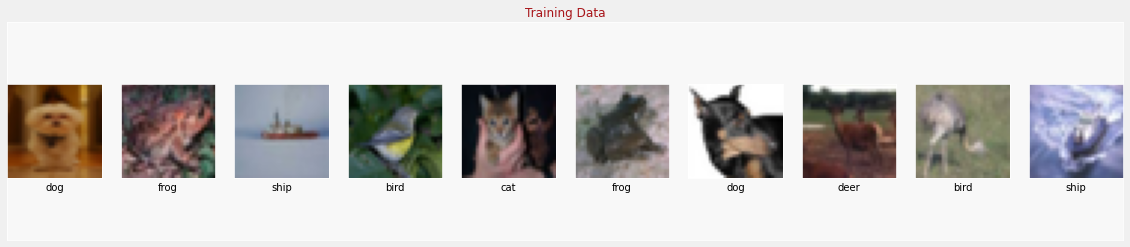

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

def prepare_data(batch_size=batch_size):
  (train_data, validation_data), info = tfds.load("cifar10", split=['train[:60%]', 'train[80%:]'], with_info = True, data_dir='./data/', download=True)
  test_data = tfds.load("cifar10", split = "test", data_dir='./data/', download=False)
  
  train_data = train_data.map(format_image)
  validation_data = validation_data.map(format_image)
  test_data = test_data.map(format_image)

  train = train_data.shuffle(buffer_size=1024).batch(batch_size)
  test_x, test_y = tuple(zip(*test_data))

  test_x = np.array(test_x)
  test_y = np.array(test_y)

  valid_x, valid_y = tuple(zip(*validation_data))

  valid_x = np.array(valid_x)
  valid_y = np.array(valid_y)
  return train, test_x, test_y, valid_x, valid_y

In [ ]:
train, test_x, test_y, valid_x, valid_y = prepare_data()

In [ ]:
test_val_accuracy = val_accuracy = sm.accuracy_score
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

### Define custom layers to allow gradient flowing

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=5, padding='same', activation=tf.nn.relu, **kwargs):
        self.filters = filters
        self.kernel_size = (kernel_size, kernel_size)
        self.activation = activation
        # Added batch norm
        self.batch_norm = tf.keras.layers.BatchNormalization()

        self.padding = padding
        super(CustomConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
       
        shape = (input_shape[:-1] + (self.filters, 0))[:-1]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer=tf.keras.initializers.GlorotUniform())

        super(CustomConv2D, self).build(input_shape)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.filters,), dtype='float32'),
            trainable=True)

    def call(self, x, W, bias, strides=1):
        x = tf.nn.conv2d(x, W, strides=strides, padding='SAME')
        x = tf.nn.bias_add(x, bias)
        x = self.batch_norm(x)

        x = self.activation(x)

        return x
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

### Define optimizee

In [ ]:
class Cifar10Optimizee(Model):
    def __init__(self):
        super(Cifar10Optimizee, self).__init__()
        # Now we initalize the needed layers - order does not matter.
        # -----------------------------------------------------------
        # CNN LAYERS
        self.conv1 = CustomConv2D(16)
        self.maxp1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = CustomConv2D(32)
        self.maxp2 = tf.keras.layers.MaxPooling2D()

        ## CNN classifiction layers
        self.conv4 = CustomConv2D(10)

        self.average_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.softmax = tf.keras.activations.softmax
                        
        # keep track of training losses
        self.training_losses, self.validation_losses = [], []
        self.step_training_losses, self.step_validation_losses = [], []

        # keep track of validation losses
        self.validation_losses= []
    
    def call(self, inputs, weights):
        x = self.conv1(inputs, weights[0], weights[1])
        x = self.maxp1(x)

        x = self.conv2(x, weights[2], weights[3])
        x = self.maxp2(x)

        x = self.conv4(x, weights[4], weights[5])
        x = self.average_pool(x)

        return self.softmax(x)

### Define methods for training LSTM optimizer and Optimizee

In [ ]:
def train_optimizer(train_data, epochs=100, steps_limit=None):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data, for_optimizer=True, steps_limit=steps_limit)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))

def train_model(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))

def get_validation_data():
    """
    Helper function to compute and retrieve validation loss and validation accuracy
    """
    # validation dataset
    validation_predictions = model(valid_x, model.tensor_trainable_weights)
    validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)

    # Take the max value after prediction for accuracy metric
    validation_predictions = np.argmax(validation_predictions, axis=1) 
    validation_accuracy = val_accuracy(y_true=valid_y, y_pred=validation_predictions)

    return validation_loss, validation_accuracy

In [ ]:
def train_data_for_one_epoch(train_data, for_optimizer=False, steps_limit=100): 
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    avg_validation_loss = []
    avg_validation_accuracy = []
    avg_loss = []

    for step, (x_batch_train, y_batch_train) in enumerate(train):
      
        if for_optimizer:
          loss = apply_optimizer_gradient(x_batch_train, y_batch_train)
        else:
          loss = apply_gradient(x_batch_train, y_batch_train)
        model.step_training_losses.append(loss)
        avg_loss.append(loss)

        validation_loss, validation_accuracy = get_validation_data()

        # save per step losses
        model.step_validation_losses.append(validation_loss)

        # store validation data
        avg_validation_loss.append(validation_loss)
        avg_validation_accuracy.append(validation_accuracy) 

        pbar.set_description("Training loss for step %s: %.4f val_loss %.4f val_acc %.3f" % (
            int(step), float(loss), float(validation_loss), float(validation_accuracy)
        ))
        pbar.update()

    avg_loss = np.mean(avg_loss)
    avg_validation_loss = np.mean(avg_validation_loss)
    avg_validation_accuracy = np.mean(avg_validation_accuracy)
    return avg_loss, avg_validation_loss, avg_validation_accuracy

def apply_optimizer_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    losses = []
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)

        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch(model.tensor_trainable_weights)

                predictions = model(x_batch_train, model.tensor_trainable_weights)  
                loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
              
                losses.append(loss_value)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                              for i in range(len(model.tensor_trainable_weights))]

        
        losses = tf.reduce_sum(losses)
        
        # calculate the loss against all losses of the optimizee
        lstm_gradients = tape_master.gradient(losses, LSTM_optimizer.trainable_weights)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 0.1)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    # calculate average loss
    losses /= LSTM_optimizer.num_unroll
    return losses

def apply_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape:
        tape.watch(model.tensor_trainable_weights)

        predictions = model(x_batch_train, model.tensor_trainable_weights)  
        loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

        gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      
        loss = loss_value
        # Retrieve new results from optimizer
        lstm_optimizer_results = LSTM_optimizer(gradients) 
        # update trainable weights based on the optimer change for that step
        model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                          for i in range(len(model.tensor_trainable_weights))]    
        
    return loss

In [ ]:
def initialize_model():
    # Input Shapes
    model.conv1.build((3, 3, 3, 16))
    model.conv2.build((4, 3, 16, 32))
    model.conv4.build((3, 3, 32, 10)) 

    model.tensor_trainable_weights = model.trainable_weights

### Define LSTM Optimizer

In [ ]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, batch_size, num_unroll, preprocessing_value=10, **kwargs):
        super().__init__(**kwargs)

        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.lstm_cell_list = []
        self.cnn_batches = [432, 16, 6144, 32, 2880, 10]
        self.preprocessing_value = preprocessing_value
        self.num_cnn_layers = len(self.cnn_batches)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.lstm_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_layers)])
            
        self.refresh_state()  # initialize state 
        self.num_unroll = num_unroll
        
    def refresh_state(self): 
        # refresh lstms state list
        self.state_list = [self.lstm_cells.get_initial_state(batch_size = self.cnn_batches[i], dtype = 'float') for i in range(self.num_cnn_layers)]

    def preprocess_inputs(self, flattened_grad):
      # Preprocessing
      preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

      condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
      case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
      case_false1 = -1
      preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

      case_true2 = np.sign(flattened_grad)
      case_false2 = np.exp(self.preprocessing_value) * flattened_grad
      preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)
      return preprocessed_inputs
  
    
    def cnn_layers_call(self, cnn_layers_gradients):
        g_new_list = []
        for i in range(self.num_cnn_layers):
            gradient = cnn_layers_gradients[i] # The gradient of the i-th parameter
            state = self.state_list[i]    
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell

            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            cell_output, state = self.lstm_cells(preprocessed_inputs, state) 
            cell_output = self.batch_norm(cell_output)
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
            self.state_list[i] = state # update the state
            if i % 2 == 0:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1], gradient.shape[2], gradient.shape[3]]) # reshape the update back to the dimension of the gradients
            else:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], ]) # reshape bias
            cell_output = cell_output * 0.001
            g_new_list.append(cell_output)
        
        return g_new_list
    
    def call(self, gradients):
      
        return self.cnn_layers_call(gradients)

### Train optimizer and optimizee

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=2, batch_size=batch_size, num_unroll=20, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 149: 1.6941 val_loss 1.7336 val_acc 0.367: 100%|██████████| 150/150 


 Epoch: 0 => loss: 1.7576 ,avg_val_loss: 1.8463 avg_val_acc: 0.3587, current_val_Acc 0.3675 



In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_model(train, epochs=3)

Training loss for step 149: 2.2474 val_loss 2.2638 val_acc 0.167: 100%|██████████| 150/150 


 Epoch: 0 => loss: 2.2873 ,avg_val_loss: 2.2863 avg_val_acc: 0.1359, current_val_Acc 0.1670 



Training loss for step 149: 2.2244 val_loss 2.2063 val_acc 0.196: 100%|██████████| 150/150 


 Epoch: 1 => loss: 2.2354 ,avg_val_loss: 2.2346 avg_val_acc: 0.1742, current_val_Acc 0.1957 



Training loss for step 149: 2.1769 val_loss 2.1625 val_acc 0.217: 100%|██████████| 150/150 


 Epoch: 2 => loss: 2.1853 ,avg_val_loss: 2.1835 avg_val_acc: 0.1942, current_val_Acc 0.2174 



## Define Cifar Model for hand crafted optimizers

In [ ]:
class NormalCifarModel(tf.keras.Model):

    def __init__(self):
        super(NormalCifarModel, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', name='conv_1')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.cnn2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu', name='conv_2')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

        self.cnn4 = tf.keras.layers.Conv2D(10, kernel_size=(3, 3), strides=(1,1), activation='relu', name='conv_3')
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.softmax = tf.keras.activations.softmax

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.pool1(x)
        x = self.cnn2(x)
        x = self.pool2(x)

        x = self.cnn4(x)
        x = self.avg_pool(x)
        return self.softmax(x)

In [ ]:
def train_data_for_one_epoch_hand_crafted(model, optimizer, steps=None, steps_limit=None):
  # store per step
  step_train_losses, step_valid_losses = [], []

  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      if steps_limit:
        if steps == steps_limit:
        # if we reach defined number of steps break
          break
        else:
          steps += 1

      logits, loss_value = apply_gradient_hand_crafted_models(model, optimizer, x_batch_train, y_batch_train)
      
      step_train_losses.append(loss_value)
      valid_losses, validation_accuracy = perform_validation(model)
      step_valid_losses.append(valid_losses)

      pbar.set_description("Training loss for step %s: %.4f, validation loss: %.4f, validation accuracy: %.4f" % (int(step), float(loss_value), float(valid_losses), float(validation_accuracy)))
      pbar.update()

  return step_train_losses, step_valid_losses, steps

In [ ]:
def perform_validation(model):
  val_logits = model(valid_x)
  val_loss = loss_object(y_true=valid_y, y_pred=val_logits)
  
  val_logits = np.argmax(val_logits, axis=1) 
  current_val_accuracy = val_accuracy(np.array(valid_y), val_logits)
  return val_loss, current_val_accuracy

In [ ]:
def apply_gradient_hand_crafted_models(model, optimizer, train_X, train_y):
    with tf.GradientTape() as tape:
      predictions = model(train_X)
      current_loss = loss_object(train_y, predictions)

    gradients = tape.gradient(current_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return predictions, current_loss

In [ ]:
def train_hand_crafted_models(model, optimizer, epochs=1, steps_limit=None):
  train_losses, valid_losses = [], []
  steps_train_losses, steps_valid_losses = [], []
  validation_accuracy_data = []
  steps = None
  for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    current_step_train_losses, current_step_valid_losses, steps = train_data_for_one_epoch_hand_crafted(model, optimizer, steps, steps_limit)
    train_losses.append(np.mean(current_step_train_losses))
    valid_losses.append(np.mean(current_step_valid_losses)) 
    steps_train_losses += current_step_train_losses
    steps_valid_losses += current_step_valid_losses

    _ , validation_accuracy = perform_validation(model)
    validation_accuracy_data.append(validation_accuracy)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(current_step_train_losses)), float(np.mean(current_step_valid_losses)), float(validation_accuracy)))
    
  history_data = {
      "loss": np.array(train_losses),
      "valid_loss": np.array(valid_losses),
      "steps_train_losses": np.array(steps_train_losses),
      "steps_valid_losses": np.array(steps_valid_losses),
      "val_accuracy": np.array(validation_accuracy_data)
  }
  return history_data

## Define plot methods and accuracy methods

In [ ]:
def plot_steps_train_results():
  plt.plot(np.array(model.step_training_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_train_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_train_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_train_losses'], label='SGD optimizer')
  plt.plot(adagrad_history['steps_train_losses'], label='Adagrad optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Training Loss') 
  plt.title('Hand crafted and learned Optimizer losses CIFAR-10')
  # show a legend on the plot
  plt.legend(loc=1)

def plot_steps_valid_results():
  plt.plot(np.array(model.step_validation_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_valid_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_valid_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_valid_losses'], label='SGD optimizer')
  plt.plot(adagrad_history['steps_valid_losses'], label='Adagrad optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Validation Loss') 
  plt.title('Hand crafted and learned Optimizer losses CIFAR-10')
  # show a legend on the plot
  plt.legend(loc=1)


In [ ]:
def print_accuracy_report(optimizer_name, test_y, preds):
    print(f"***** {optimizer_name} Accuracy metrics******")
    print(sm.classification_report(test_y, preds, target_names=class_names))
    print()

def print_accuracy_reports():
  print_accuracy_report("LSTM_optimizer", test_y, np.argmax(lstm_optimizer_preds, axis=1))
  print_accuracy_report("Adagrad", test_y, np.argmax(adagrad_preds, axis=1))
  print_accuracy_report("RMSProp", test_y, np.argmax(rms_preds, axis=1))
  print_accuracy_report("ADAM", test_y, np.argmax(adam_preds, axis=1))
  print_accuracy_report("SGD", test_y, np.argmax(sgd_preds, axis=1))

## Train hand crafted optimizers

In [ ]:
adam_model = NormalCifarModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=3)
rmsprop_model = NormalCifarModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=3)
sgd_model = NormalCifarModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=3)
adagrad_model = NormalCifarModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=3)

Start of epoch 0


Training loss for step 149: 2.2350, validation loss: 2.2356, validation accuracy: 0.1925: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.2781  Validation Loss: 2.2750, Validation Accuracy 0.1925
Start of epoch 1


Training loss for step 149: 2.1815, validation loss: 2.1539, validation accuracy: 0.2429: 100%|██████████| 150/150 


 Epoch 1: Train loss: 2.2075  Validation Loss: 2.2021, Validation Accuracy 0.2429
Start of epoch 2


Training loss for step 149: 2.1586, validation loss: 2.1220, validation accuracy: 0.2556: 100%|██████████| 150/150 


 Epoch 2: Train loss: 2.1444  Validation Loss: 2.1366, Validation Accuracy 0.2556
Start of epoch 0


Training loss for step 149: 2.1069, validation loss: 2.1228, validation accuracy: 0.2593: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.1705  Validation Loss: 2.1755, Validation Accuracy 0.2593
Start of epoch 1


Training loss for step 149: 1.9268, validation loss: 1.9458, validation accuracy: 0.3085: 100%|██████████| 150/150 


 Epoch 1: Train loss: 2.0020  Validation Loss: 2.0020, Validation Accuracy 0.3085
Start of epoch 2


Training loss for step 149: 1.8714, validation loss: 1.8638, validation accuracy: 0.3492: 100%|██████████| 150/150 


 Epoch 2: Train loss: 1.9206  Validation Loss: 1.9173, Validation Accuracy 0.3492
Start of epoch 0


Training loss for step 149: 2.2946, validation loss: 2.3008, validation accuracy: 0.1003: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.3022  Validation Loss: 2.3030, Validation Accuracy 0.1003
Start of epoch 1


Training loss for step 149: 2.2914, validation loss: 2.2972, validation accuracy: 0.1248: 100%|██████████| 150/150 


 Epoch 1: Train loss: 2.2974  Validation Loss: 2.2991, Validation Accuracy 0.1248
Start of epoch 2


Training loss for step 149: 2.2960, validation loss: 2.2933, validation accuracy: 0.1442: 100%|██████████| 150/150 


 Epoch 2: Train loss: 2.2933  Validation Loss: 2.2954, Validation Accuracy 0.1442
Start of epoch 0


Training loss for step 149: 2.2978, validation loss: 2.2977, validation accuracy: 0.1212: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.2996  Validation Loss: 2.2991, Validation Accuracy 0.1212
Start of epoch 1


Training loss for step 149: 2.2951, validation loss: 2.2952, validation accuracy: 0.1232: 100%|██████████| 150/150 


 Epoch 1: Train loss: 2.2962  Validation Loss: 2.2963, Validation Accuracy 0.1232
Start of epoch 2


Training loss for step 149: 2.2949, validation loss: 2.2930, validation accuracy: 0.1164: 100%|██████████| 150/150 


 Epoch 2: Train loss: 2.2935  Validation Loss: 2.2941, Validation Accuracy 0.1164


## Plot initial graphs

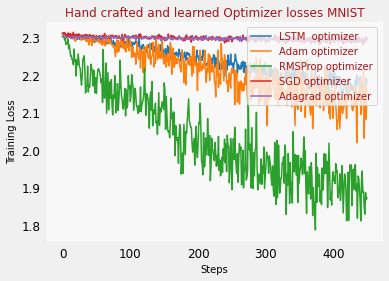

In [ ]:
plot_steps_train_results()

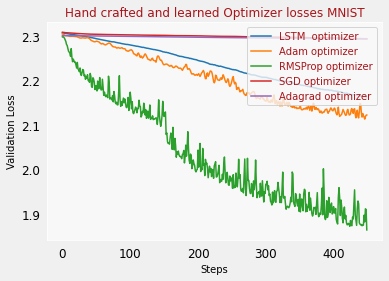

In [ ]:
plot_steps_valid_results()

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.24      0.44      0.31      1000
  automobile       0.18      0.58      0.27      1000
        bird       0.19      0.04      0.07      1000
         cat       0.18      0.09      0.11      1000
        deer       0.14      0.03      0.05      1000
         dog       0.29      0.04      0.07      1000
        frog       0.24      0.57      0.34      1000
       horse       0.18      0.08      0.11      1000
        ship       0.33      0.27      0.30      1000
       truck       0.27      0.07      0.11      1000

    accuracy                           0.22     10000
   macro avg       0.22      0.22      0.17     10000
weighted avg       0.22      0.22      0.17     10000


***** Adagrad Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.12      0.59      0.20      1000
  automobile       0.06      0.02      0.03      1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train optimizer

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=2, batch_size=batch_size, num_unroll=20, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 312: 2.1238 val_loss 2.0912 val_acc 0.226: 100%|██████████| 313/313 


 Epoch: 0 => loss: 2.0557 ,avg_val_loss: 2.1262 avg_val_acc: 0.2287, current_val_Acc 0.2262 



In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_model(train, epochs=2)

Training loss for step 312: 2.2591 val_loss 2.2287 val_acc 0.143: 100%|██████████| 313/313 


 Epoch: 0 => loss: 2.2697 ,avg_val_loss: 2.2646 avg_val_acc: 0.1350, current_val_Acc 0.1433 



Training loss for step 312: 2.2402 val_loss 2.1900 val_acc 0.154: 100%|██████████| 313/313 


 Epoch: 1 => loss: 2.2190 ,avg_val_loss: 2.2055 avg_val_acc: 0.1622, current_val_Acc 0.1541 



In [ ]:
adam_model = NormalCifarModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=2)
rmsprop_model = NormalCifarModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=2)
sgd_model = NormalCifarModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=2)
adagrad_model = NormalCifarModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=2)

Start of epoch 0


Training loss for step 312: 1.8651, validation loss: 1.9228, validation accuracy: 0.3305: 100%|██████████| 313/313 


 Epoch 0: Train loss: 2.0575  Validation Loss: 2.0682, Validation Accuracy 0.3305
Start of epoch 1


Training loss for step 312: 1.7145, validation loss: 1.8076, validation accuracy: 0.3684: 100%|██████████| 313/313 


 Epoch 1: Train loss: 1.8264  Validation Loss: 1.8420, Validation Accuracy 0.3684
Start of epoch 0


Training loss for step 312: 2.0573, validation loss: 2.0448, validation accuracy: 0.2935: 100%|██████████| 313/313 


 Epoch 0: Train loss: 2.1324  Validation Loss: 2.1407, Validation Accuracy 0.2935
Start of epoch 1


Training loss for step 312: 1.8684, validation loss: 2.0067, validation accuracy: 0.2906: 100%|██████████| 313/313 


 Epoch 1: Train loss: 1.9918  Validation Loss: 2.0036, Validation Accuracy 0.2906
Start of epoch 0


Training loss for step 312: 2.2861, validation loss: 2.2900, validation accuracy: 0.1409: 100%|██████████| 313/313 


 Epoch 0: Train loss: 2.2979  Validation Loss: 2.2975, Validation Accuracy 0.1409
Start of epoch 1


Training loss for step 312: 2.3110, validation loss: 2.2718, validation accuracy: 0.1831: 100%|██████████| 313/313 


 Epoch 1: Train loss: 2.2828  Validation Loss: 2.2820, Validation Accuracy 0.1831
Start of epoch 0


Training loss for step 312: 2.3030, validation loss: 2.3031, validation accuracy: 0.0990: 100%|██████████| 313/313 


 Epoch 0: Train loss: 2.3046  Validation Loss: 2.3049, Validation Accuracy 0.0990
Start of epoch 1


Training loss for step 312: 2.3062, validation loss: 2.3014, validation accuracy: 0.1235: 100%|██████████| 313/313 


 Epoch 1: Train loss: 2.3020  Validation Loss: 2.3022, Validation Accuracy 0.1235


### Plot results

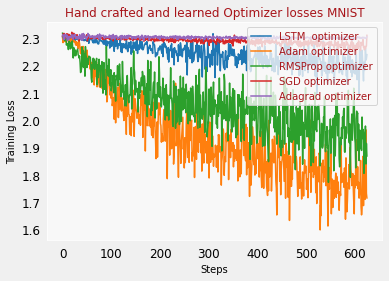

In [ ]:
plot_steps_train_results()

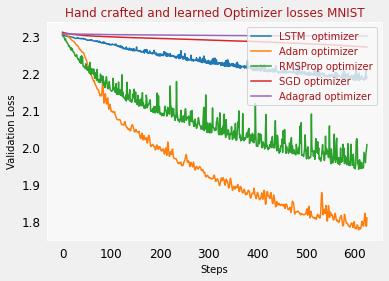

In [ ]:
plot_steps_valid_results()

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.02      0.02      0.02      1000
  automobile       0.23      0.43      0.30      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.16      0.89      0.27      1000
       truck       0.09      0.14      0.11      1000

    accuracy                           0.15     10000
   macro avg       0.05      0.15      0.07     10000
weighted avg       0.05      0.15      0.07     10000


***** Adagrad Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.17      0.08      0.11      1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train for longer test

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=2, batch_size=batch_size, num_unroll=20, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=3)

Training loss for step 312: 2.1880 val_loss 2.2499 val_acc 0.156: 100%|██████████| 313/313 



 Epoch: 0 => loss: 2.2679 ,avg_val_loss: 2.2683 avg_val_acc: 0.1414, current_val_Acc 0.1562 



Training loss for step 272: 26.3090 val_loss 21.9499 val_acc 0.102:  87%|████████▋ | 273/313 
Training loss for step 103: 9.2557 val_loss 9.0644 val_acc 0.101:  33%|███▎      | 104/313 
Training loss for step 312: 2.2711 val_loss 2.1923 val_acc 0.153: 100%|██████████| 313/313 



 Epoch: 1 => loss: 2.2109 ,avg_val_loss: 2.2092 avg_val_acc: 0.1589, current_val_Acc 0.1527 



Training loss for step 312: 2.0586 val_loss 2.2984 val_acc 0.156: 100%|██████████| 313/313 



 Epoch: 2 => loss: 2.2178 ,avg_val_loss: 2.2173 avg_val_acc: 0.1556, current_val_Acc 0.1556 



In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_model(train, epochs=3)

Training loss for step 199: 2.1261 val_loss 2.1630 val_acc 0.211: 100%|██████████| 200/200 



 Epoch: 0 => loss: 2.1648 ,avg_val_loss: 2.1654 avg_val_acc: 0.1913, current_val_Acc 0.2108 



Training loss for step 199: 1.9720 val_loss 1.9549 val_acc 0.301: 100%|██████████| 200/200 



 Epoch: 1 => loss: 2.0121 ,avg_val_loss: 2.0081 avg_val_acc: 0.2632, current_val_Acc 0.3006 



Training loss for step 199: 1.9537 val_loss 1.9313 val_acc 0.299: 100%|██████████| 200/200 



 Epoch: 2 => loss: 1.9439 ,avg_val_loss: 1.9436 avg_val_acc: 0.2991, current_val_Acc 0.2990 



In [ ]:
adam_model = NormalCifarModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=3)
rmsprop_model = NormalCifarModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=3)
sgd_model = NormalCifarModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=3)
adagrad_model = NormalCifarModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=3)

Start of epoch 0


Training loss for step 199: 1.6925, validation loss: 1.6908, validation accuracy: 0.3822: 100%|██████████| 200/200 



 Epoch 0: Train loss: 1.9590  Validation Loss: 1.9543, Validation Accuracy 0.3822
Start of epoch 1


Training loss for step 199: 1.4567, validation loss: 1.4595, validation accuracy: 0.4699: 100%|██████████| 200/200 



 Epoch 1: Train loss: 1.5668  Validation Loss: 1.5697, Validation Accuracy 0.4699
Start of epoch 2


Training loss for step 199: 1.3820, validation loss: 1.4453, validation accuracy: 0.4774: 100%|██████████| 200/200 



 Epoch 2: Train loss: 1.4158  Validation Loss: 1.4267, Validation Accuracy 0.4774
Start of epoch 0


Training loss for step 199: 1.8144, validation loss: 1.8311, validation accuracy: 0.3258: 100%|██████████| 200/200 



 Epoch 0: Train loss: 2.0111  Validation Loss: 2.0092, Validation Accuracy 0.3258
Start of epoch 1


Training loss for step 199: 1.6503, validation loss: 1.6062, validation accuracy: 0.4134: 100%|██████████| 200/200 



 Epoch 1: Train loss: 1.7337  Validation Loss: 1.7348, Validation Accuracy 0.4134
Start of epoch 2


Training loss for step 199: 1.5513, validation loss: 1.5016, validation accuracy: 0.4629: 100%|██████████| 200/200 



 Epoch 2: Train loss: 1.5916  Validation Loss: 1.5939, Validation Accuracy 0.4629
Start of epoch 0


Training loss for step 199: 2.2915, validation loss: 2.2922, validation accuracy: 0.1766: 100%|██████████| 200/200 



 Epoch 0: Train loss: 2.2979  Validation Loss: 2.2976, Validation Accuracy 0.1766
Start of epoch 1


Training loss for step 199: 2.2846, validation loss: 2.2815, validation accuracy: 0.1943: 100%|██████████| 200/200 



 Epoch 1: Train loss: 2.2868  Validation Loss: 2.2873, Validation Accuracy 0.1943
Start of epoch 2


Training loss for step 199: 2.2594, validation loss: 2.2626, validation accuracy: 0.2084: 100%|██████████| 200/200 



 Epoch 2: Train loss: 2.2723  Validation Loss: 2.2731, Validation Accuracy 0.2084
Start of epoch 0


Training loss for step 199: 2.2981, validation loss: 2.2997, validation accuracy: 0.0968: 100%|██████████| 200/200 



 Epoch 0: Train loss: 2.3012  Validation Loss: 2.3009, Validation Accuracy 0.0968
Start of epoch 1


Training loss for step 199: 2.2986, validation loss: 2.2978, validation accuracy: 0.0965: 100%|██████████| 200/200 



 Epoch 1: Train loss: 2.2985  Validation Loss: 2.2987, Validation Accuracy 0.0965
Start of epoch 2


Training loss for step 199: 2.2921, validation loss: 2.2961, validation accuracy: 0.0991: 100%|██████████| 200/200 



 Epoch 2: Train loss: 2.2967  Validation Loss: 2.2970, Validation Accuracy 0.0991


### Plot results

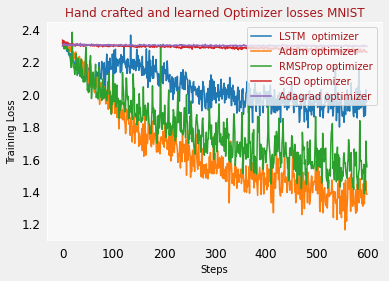

In [ ]:
plot_steps_train_results()

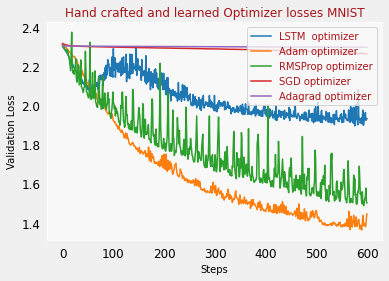

In [ ]:
plot_steps_valid_results()

### Accuracy

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.33      0.40      0.36      1000
  automobile       0.38      0.23      0.28      1000
        bird       0.22      0.07      0.11      1000
         cat       0.18      0.35      0.24      1000
        deer       0.27      0.16      0.20      1000
         dog       0.27      0.35      0.30      1000
        frog       0.38      0.24      0.29      1000
       horse       0.33      0.20      0.25      1000
        ship       0.35      0.49      0.40      1000
       truck       0.30      0.43      0.36      1000

    accuracy                           0.29     10000
   macro avg       0.30      0.29      0.28     10000
weighted avg       0.30      0.29      0.28     10000


***** Adagrad Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.08      0.03      0.04      1000
  automobile       0.14      0.00      0.00      1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
